In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
import matplotlib as mpl
def mpl_set():
    mpl.rcParams['xtick.labelsize'] = 'large'
    mpl.rcParams['ytick.labelsize'] = 'large'
    mpl.rcParams['axes.labelsize'] = 'x-large'
    mpl.rcParams['legend.fontsize'] = 'x-large'
    mpl.rcParams['axes.titlesize'] = 'xx-large'
    mpl.rcParams['figure.titlesize'] = 'xx-large'

In [3]:
import warnings
warnings.simplefilter('ignore')

In [42]:
from sklearn.datasets import make_regression, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                             f1_score, roc_auc_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from regression import plot_data
from regression import CMAP

import time

In [5]:
def calculate_metrics(y_true, y_pred, *metrics):
    for metric in metrics:
        print("{} = {:.3f}".format(metric.__name__, metric(y_true, y_pred)))

regression_metrics = [r2_score, mean_squared_error]
classification_metrics = [accuracy_score, f1_score]

# GP models 

We provide a scikt-learn-like wrapper over [GPy](http://sheffieldml.github.io/GPy/) library for the most common models based on Gaussian processes

In [6]:
from edrgp.gp_model import GaussianProcessClassifier, GaussianProcessRegressor

print(GaussianProcessRegressor(), GaussianProcessClassifier(), sep='\n\n')

GaussianProcessRegressor(Y_metadata=None, kernel_options=None, kernels=None,
             mean_function=None, method='optimize', noise_var=1.0,
             normalizer=None)

GaussianProcessClassifier(Y_metadata=None, kernel_options=None, kernels=None,
             mean_function=None, method='optimize')


The main parameters that should be carefully considered are `kernels`, `kernel_options`, `method` and `normalizer` for regression. Below are some examples, for more details see the documentation.

## Regression 

### `normalizer` 

Let's consider linear function

In [7]:
def generate_linear_data(bias):
    X, y = make_regression(n_samples=300, n_features=2, noise=0.5, bias=bias, 
                           random_state=0)
    return train_test_split(X, y, test_size=0.33, random_state=42)

r2_score = 1.000
mean_squared_error = 0.260


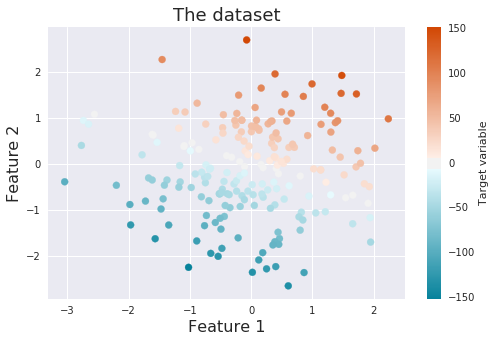

In [8]:
X_train, X_test, y_train, y_test = generate_linear_data(bias=0)
plot_data(X_train, y_train)

# Let's use GP with linear kernel
GPR = GaussianProcessRegressor('Linear')
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

As we can see the results are good, but let's add bias to target. It is the same function but with bias

r2_score = -1.628
mean_squared_error = 10241.449


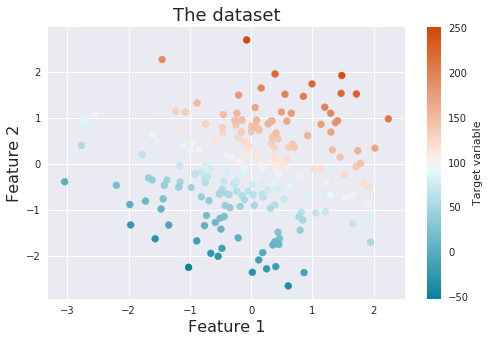

In [9]:
X_train, X_test, y_train, y_test = generate_linear_data(bias=100)
plot_data(X_train, y_train)

GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

We can see that result is very strange. It leads us to fact that we should normalize target before passing data to GaussianProcessRegressor. To do it you can specify `normalizer=True`.

In [10]:
GPR = GaussianProcessRegressor('Linear', normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

r2_score = 0.983
mean_squared_error = 66.535


### `ARD` for RBF kernel 

In [11]:
from edrgp.datasets import get_beta_inputs, get_edr_target

Consider nonlinear model depending only on first two features of data $ y =(x_1^3+x_2)(x_1-x_2^3)$

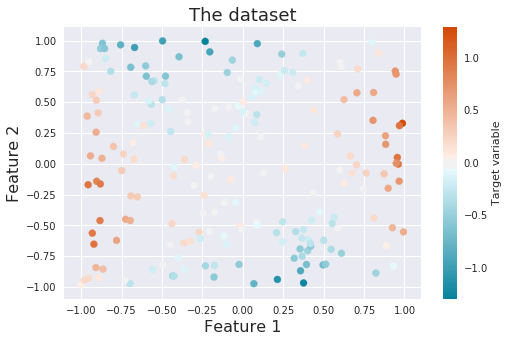

In [12]:
X = get_beta_inputs(200, 5)
y = get_edr_target(X[:, :2], sigma=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

plot_data(X[:, :2], y)

Here we can see that kernel option `ARD=True` for RBF kernel can show better performance. This option means that there is not only one lengthscale for all features, but every feature has it's own lengthscale

In [13]:
print('ARD = False\n==========')
GPR = GaussianProcessRegressor('RBF', normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)
print()
print("ARD = True\n=========")
GPR = GaussianProcessRegressor('RBF', [{'ARD': True}], normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

ARD = False
r2_score = 0.783
mean_squared_error = 0.039

ARD = True
r2_score = 0.910
mean_squared_error = 0.016


This option is also applicable for classification

## Classification 

In [65]:
def generate_circles_data():
    X, y = make_circles(n_samples=200, noise=0.1, random_state=0, factor=0.7)
    return X, y, train_test_split(X, y, test_size=0.33, random_state=42)

def plot_classificaton_data(X, y):
    colors = ['dodgerblue', 'darkorange']
    for target, c in zip(np.unique(y), colors):
        plt.scatter(X[:, 0][y==target], X[:, 1][y==target], c=c,
                    label="Clas {}".format(target), s=50, edgecolors='k')
    plt.legend()
    plt.title('The dataset', fontsize=18)
    plt.xlabel('Feature 1', fontsize=16)
    plt.ylabel('Feature 2', fontsize=16)

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

def plot_desicion_rule(model, X, y):
    plt.figure(figsize=(7, 6))
    xx, yy = get_grid(X)
    model.fit(X, y)
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, predicted, cmap=CMAP, alpha=0.1, shading='gouraud')
    plot_classificaton_data(X, y)

Consider circles dataset

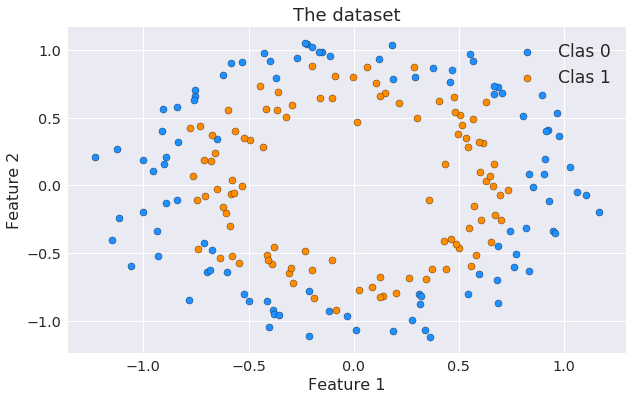

In [66]:
X, y, (X_train, X_test, y_train, y_test) = generate_circles_data()
plt.figure(figsize=(10, 6))
plot_classificaton_data(X, y)

It's obvious that linear kenrel will not work well for this data, but let's see it 

accuracy_score = 0.470
f1_score = 0.444
roc_auc_score = 0.466


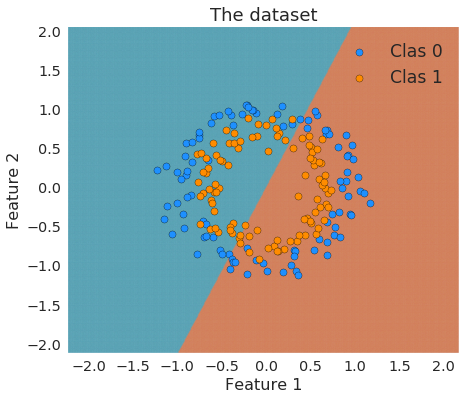

In [67]:
GPC = GaussianProcessClassifier('Linear')
GPC.fit(X_train, y_train)
y_pred = GPC.predict(X_test)
y_pred_proba = GPC.predict_proba(X_test)
calculate_metrics(y_test, y_pred, *classification_metrics)
print("{} = {:.3f}".format(roc_auc_score.__name__, 
                           roc_auc_score(y_test, y_pred_proba)))
plot_desicion_rule(GPC, X, y)

We can achieve better perfomance with non-linear kernel, for example RBF

accuracy_score = 0.879
f1_score = 0.875
roc_auc_score = 0.989


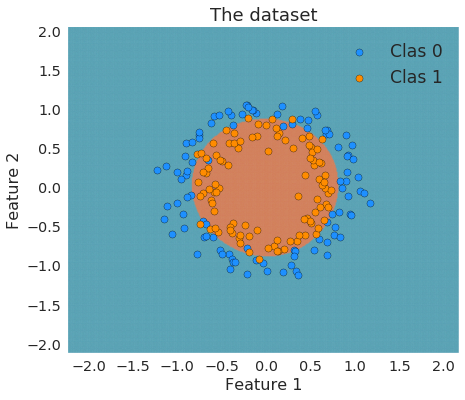

In [68]:
GPC = GaussianProcessClassifier('RBF')
GPC.fit(X_train, y_train)
y_pred = GPC.predict(X_test)
y_pred_proba = GPC.predict_proba(X_test)
calculate_metrics(y_test, y_pred, *classification_metrics)
print("{} = {:.3f}".format(roc_auc_score.__name__, 
                           roc_auc_score(y_test, y_pred_proba)))

plot_desicion_rule(GPC, X, y)

## `method` = {optimize, optimize_restarts} 

You can initialize GP model with one of this options. _optimize_ means that optimization process during fit will only start once. _optimize_restarts_ means that it will run optimization process several times and than choose the best run. Moreover in `fit` we can specify number of restarts (default 10) and whether to print results on every run.

In [18]:
GPC = GaussianProcessClassifier('RBF', method='optimize_restarts')

for num_restarts, verbose in zip([5, 10], [True, False]):
    mes = "Number of restarts = {}, verbose = {}".format(num_restarts, verbose)
    print(mes)
    print("="*len(mes))
    GPC.fit(X_train, y_train, num_restarts=num_restarts, verbose=verbose)
    print()
    y_pred = GPC.predict(X_test)
    y_pred_proba = GPC.predict_proba(X_test)
    calculate_metrics(y_test, y_pred, *classification_metrics)
    print("{} = {:.3f}".format(roc_auc_score.__name__, 
                               roc_auc_score(y_test, y_pred_proba)))
    print()

# plot_desicion_rule(GPC, X, y)

Number of restarts = 5, verbose = True
Optimization restart 1/5, f = 55.50722288155322
Optimization restart 2/5, f = 50.173500125867626
Optimization restart 3/5, f = 53.085385231423
Optimization restart 4/5, f = 56.002476507999795
Optimization restart 5/5, f = 56.021009448874345

accuracy_score = 0.879
f1_score = 0.875
roc_auc_score = 0.989

Number of restarts = 10, verbose = False

accuracy_score = 0.864
f1_score = 0.862
roc_auc_score = 0.988



 # EDR 

Effective dimension reduction is supervised DR method. It allows to find the linear combinations of features from which the model depends most. Is is based on dimension reduction in gradient space.

In [19]:
from edrgp import EffectiveDimensionalityReduction as EDR
from edrgp.utils import CustomPCA

In [20]:
EDR()

EffectiveDimensionalityReduction(dr_transformer=None, estimator=None,
                 n_components=None, normalize=True, preprocessor=None,
                 step=None)

`estimator` is some model that can be fitted to data and that can predict gradients. `dr_transformer` reduce the dimension in gradient space, we strongly recommend to use `SVDTransformer`. `n_components` specifies the dimension of new space after applying `EDR` to data. `normalize` and `preprocessor` normalizes and preprocess data. Below are some examples, you can read more in docstring to model. `step` indicates whether to use iterative DR or not, it can be integer (number of components to drop at each iteration) or float from 0 to 1 (number of components to drop computes using `subspace_variance_ratio_`)

Let's generate 10-d data and random projection matrix to 2-d subspace. Target will depend only on this subspace.

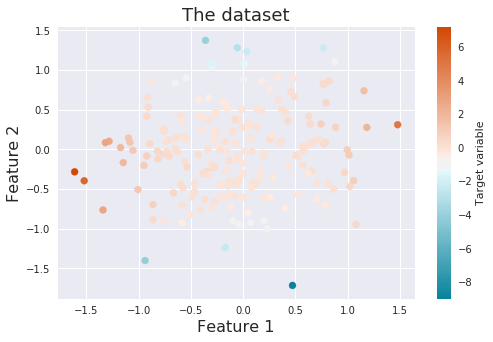

In [21]:
np.random.seed(3)

X = get_beta_inputs(200, 10)
B = np.linalg.qr(np.random.normal(size=(10, 2)))[0]
X_lower_dim = X.dot(B)
y = get_edr_target(X_lower_dim, sigma=0.1)

plot_data(X_lower_dim, y)

Using EDR model we will try to find the correct subspace spanned by columns of $B$

## Base 

In [22]:
GPR = GaussianProcessRegressor('RBF', [{'ARD': True}], normalizer=True) # normalizing target
edr = EDR(GPR, CustomPCA(), normalize=False) # not normalizing X
start = time.time()
edr.fit(X, y);
end = time.time()

Using `subspace_variance_ratio_` attribute we can estimate the number of components needed

In [26]:
mpl_set()
def plot_subsp_var(edr, title=None):
    max_n_comp = edr.subspace_variance_ratio_.size
    plt.plot(np.arange(1, max_n_comp+1), np.cumsum(edr.subspace_variance_ratio_), 'o--');
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    if title is not None:
        plt.title(title);

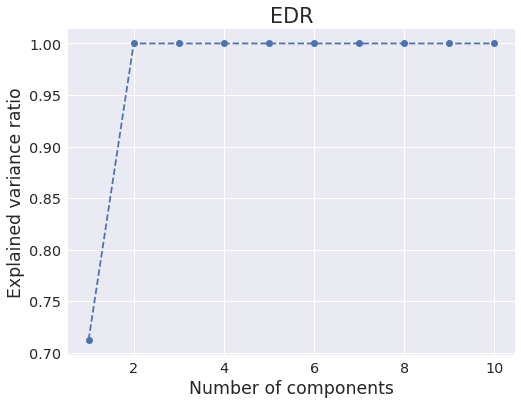

In [41]:
plt.figure(figsize=(8, 6))
plot_subsp_var(edr, "EDR")

We can see that 2 components are enough. We can measure difference between true and found subspaces using `discrepancy`.

In [28]:
from edrgp.utils import discrepancy

In [29]:
B_est = edr.components_.T[:, :2]
print("Discrepancy = {:.3f}, execution time = {:.3f} s".format(discrepancy(B, B_est), end-start))

Discrepancy = 0.135, execution time = 2.154 s


## Iterative

When we decide how many components should be in subspace we now can make more accurate estimation with iterative algorithm.

In [30]:
edr_iter = EDR(GPR, CustomPCA(), n_components=2, step=1, normalize=False)
start = time.time()
edr_iter.fit(X, y)
end = time.time()
print("Discrepancy = {:.3f}, execution time = {:.3f} s".format(discrepancy(B, edr_iter.components_.T), end-start))

Discrepancy = 0.056, execution time = 12.160 s


As we can see the results are two times better using iterative approach, although it is more time consuming

## `refit` 

Sometimes you may have some prior information about structure of projector matrix. For example it could be sparse. Then you can apply `EDR` with `SVDTransformer` to some subspace to estimate grasients and drop some noise from them. After that you can apply `refit` method to find projection matrix with desired structure.

Let's make sparse projection matrix

In [31]:
import scipy

In [32]:
B_sparse = np.linalg.qr(scipy.sparse.random(10, 2, density=0.2, random_state=11).A)[0]
y = get_edr_target(X.dot(B_sparse), sigma=0.1)

In [33]:
B_sparse

array([[ 1.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -0.60455427],
       [ 0.        , -0.01585381],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ],
       [ 0.        , -0.52123653],
       [ 0.        , -0.60214223],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ]])

In [34]:
edr.fit(X, y)
print("Discrepancy = {:.3f}".format(discrepancy(B_sparse, edr.components_.T[:, :2])))

Discrepancy = 0.061


We get good quality for subspace distance, however the structure of predicted projection patrix is not sparse

In [35]:
np.round(edr.components_[:, :2], decimals=3)

array([[ 0.111, -0.002],
       [-0.99 ,  0.016],
       [ 0.057,  0.027],
       [ 0.003,  0.005],
       [ 0.045,  0.107],
       [ 0.024, -0.242],
       [ 0.036,  0.476],
       [-0.002,  0.838],
       [ 0.   ,  0.   ],
       [ 0.   , -0.   ]])

Now, we can refit the model (the same model that we just fitted!)

In [36]:
from sklearn.decomposition import SparsePCA

In [37]:
edr.refit(SparsePCA(n_components=2, alpha=2));
np.round(edr.refit_components_.T, decimals=3)

array([[ 0.   ,  1.   ],
       [ 0.   ,  0.   ],
       [-0.648,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [-0.444,  0.   ],
       [-0.619,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ]])

It's more like sparse matrix, we also can draw the dependence between the regularisation coefficient and subsace variance ratio for found subspace

In [38]:
subsp_var_for_alpha = []
alpha_range = np.linspace(0.1, 20, 40)
for alpha in alpha_range:
    edr.refit(SparsePCA(n_components=2, alpha=alpha))
    subsp_var_for_alpha.append(np.sum(edr.refit_subspace_variance_ratio_))

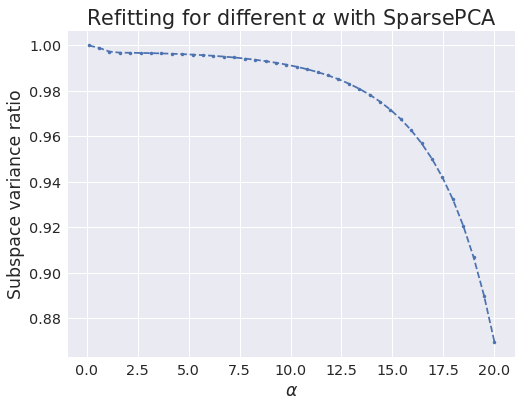

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_range, subsp_var_for_alpha, '.--')
plt.xlabel(r'$\alpha$')
plt.ylabel('Subspace variance ratio')
plt.title(r'Refitting for different $\alpha$ with SparsePCA');

Judging from this plot it it is possible to select $\alpha$ up to 12 to get the sparsest result almost without losing information.